# Chapter 9 성능개선

## 9.1 과적합
- 학습 데이터에 대해서는 예측을 잘 하지만 테스트 데이터와 같은 학습에 사용되지 않은 데이터에 대해서는 예측을 잘 못하는 현상
- 이 과적합을 방지하면서 딥런닝 모델을 학습시키는 것이 정규화 방법

### 9.1.1 데이터 증식
- 딥러닝은 많은 데이터를 요구하지만 추가 데이터를 확보하는 건 쉽지 않음. 그래서 Data augmentation 기법을 통해 임의로 새로운 데이터를 만들어 학습 데이터에 추가

In [ ]:
import torchvision.transforms as tr
import PIL

# 60x60으로 이미지 일부를 무작위로 잘라서 같은 이미지라도 매번 다른 입력 이미지로
transf = tr.Compose([tr.ToPILImage(), tr.RandomCrop(60),
tr.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.1), # 이미지 밝기, 대비, 색조 변형
                     tr.RandomHorizontalFlip(),tr.ToTensor()]) # 이미지 뒤집기

### 9.1.2 조기 종료
- 모델이 학습 데이터를 많이 공부한다면 학습 데이터에 맞춰져 모델이 최적화될 수 있으므로 적당한 기준을 정하여 모델 학습을 끊는 것이 Early Stopping 방법
- 손실 함수값이 작다고 반드시 정확도가 높은 것은 아님
- 학습 반복 횟수를 더 크게 할 경우 시험 데이터의 손실 함수값이 다시 내려오는 경우도 존재
- 시험 데이터는 오직 평가에만 사용. 모델 선택 시에는 검증 데이터 사용할 것

In [ ]:
# 라이브러리 불러오기

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# 학습, 검증, 평가 데이터 생성하기

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
dataset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                       download=True,transform=transform)
# dataset 분할
trainset, valset = torch.utils.data.random_split(dataset,[30000,20000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_sizze=32, shuffle=False)

### 9.1.3 L2 정규화
- 경계를 만들어 학습 데이터에서의 최적 변수 w(**)*에 도달하지 못하게 하며 경계 안에서만 변수를 최적화하도록 함. 따라서 v(*)로 수렴하게 됨

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-3)

### 9.1.4 드롭아웃
- 인공 신경망에서 무작위로 일정한 비율의 노드를 제외하여 학습하는 방법 (과적합 방지)
- 출력층은 예측값이 나오는 단계이므로 적용하지 않음

In [ ]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50)
    self.fc2 = nn.Linear(50,1)
    # 해당 노드에 50%를 선택해 노드를 사용하지 않겠다는 의미
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = F.relu(self.fc2(x))
    return x

### 9.1.5 배치 정규화
- 미니 배치를 이용하면 학습을 반복할 때마다 우리가 나눠 놓은 미니 배치들이 돌아가면서 사용되는데, 이때 학습을 한 번 할 때마다 입력값의 분포가 다르고 각 레이어의 입력값 분포 또한 다름
- 이전 층의 노드가 관련 변수들과 일차결합 연산을 거치고 그 값이 활성화 함수를 통해 다음 레이어로 가는 흐름에서, 활성화 함수로 들어가기 전 각 노드로 들어오는 값인 feature 값을 보정된 Normalization을 통해 항상 동일한 분포 위에 있게 함
- 입력값들의 분포를 일정하게 하여 일반적으로 학습에 대한 수렴 속도가 빠름 (overfitting 방지)

In [ ]:
nn.BatchNorm2d() # 층과 층 사이

### 9.1.6 교란 라벨 (DisturbLabel)
- 분류 문제에서 일정 비율만큼 라벨을 의도적으로 잘못된 라벨로 만들어서 학습을 방해하는 방법. 과적합을 막을 수 있음

예를 들어 클래스 수가 10개이고 교란 라벨 비율이 30% 라면 self.p_e=73/100, self.p_i=3/100이 되고, 실제 라벨이 5라면 뽑힐 라벨 분포는 (3/100, 3/100, 3/100, 3/100, 3/100, 73/100, 3/100, 3/100, 3/100, 3/100) 이 된다.

=> self.p_i는 나머지 30%를 교란된 라벨 수인 9개로 나누어 주면 됨. 즉, 3.33%
총 합은 1이 되도록 normalize

In [ ]:
# 교란 라벨 정의하기

class DisturbLabel(torch.nn.Module):
  # 교란 라벨 비율(0~100), 클래스 수
  def __init__(self,alpha,num_classes):
    super(DisturbLabel,self).__init__()
    self.alpha = alpha
    self.C = num_classes
    # 실제 라벨을 뽑을 확률(p_c)와 나머지(p_i)
    self.p_c = (1-((self.C - 1) / self.C) * (alpha / 100))
    self.p_i = (1-self.p_c)/(self.C-1)

In [ ]:
def forward(self,y):
  # 라벨이 뽑힐 확률 분포를 만들어줌 (3/100, 3/100...73/100...)
  y_tensor = y.type(torch.LongTensor).view(-1,1)
  depth = self.C
  y_one_hot = torch.ones(y_tensor.size()[0], depth) * self.p_i
  y_one_hot.scatter_(1,y_tensor, self.p_c)
  # 해당 확률을 이용해 Multinoulli 분포를 통해 샘플 뽑기
  y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,)))
  distribution = torch.distributions.OneHotCategorical(y_one_hot)
  y_disturbed = distribution.sample()
  # 10개의 원소 중 가장 큰 값의 라벨을 뽑음
  # 교란 라벨 비율이 30%라 해서 반드시 미니 배치의 30%가 교란 라벨인 건 아님
  y_disturbed = y_disturbed.max(dim=1)[1]
  return y_disturbed

In [ ]:
# 교란 라벨 선언 및 적용하기

disturblabels = DisturbLabel(alpha=30, num_classes=10)

In [ ]:
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    labels = disturblabels(labels).to(device)
    loss = criterion(outputs, labels)
    ...

### 9.1.7 교란 값 DisturbValue
- 회귀 문제에서 일정 비율만큼 라벨에 노이즈를 주입하여 학습 데이터에 대해 최적화를 방해하는 방법

In [ ]:
# 노이즈 생성하기

def noise_generator(x,alpha): # 타깃값, 노이즈 비율(0~1)
  noise = torch.normal(0,1e-8,size=(len(x),1)) # 임의로 정한 정규분포에 따른 노이즈 생성
  noise[torch.randint(0,len(x),(int(len(x)*(1-alpha)),))] = 0 # 노이즈 타깃이 아닌 값은 노이즈를 0으로
  return noise

In [ ]:
# 교란 값 선언 및 적용하기

for epoch in range(400):
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    values = values + noise_generator(values,alpha)
    loss = criterion(outputs,values)
    ...

### 9.1.8 라벨 스무딩 Label Smoothing
- 분류 문제에서 사용하는 원-핫 벡터는 0과 1로 구성되어 있고 우리는 소프트맥스나 시그모이드 함수를 통해 0과 1 사이의 예측값을 출력
- 이때, 실제값을 0과 1이 아닌, 예측값에 가깝게 낮추거나 높인 어느 정도만 맞춰도 모델이 정답이라 판단하여 과적합을 막아주는 개념
- 크로스 엔트로피 함수 nn.CrossEntropyLoss()는 실제 라벨의 원 핫 벡터를 입력으로 받을 수 없으므로 사용할 수 있도록 별도로 손실 함수를 만들어 줘야 함

In [ ]:
# 라벨 스무딩 정의 및 선언하기

class LabelSmoothingLoss(nn.Module):
  def __init__(self,classes,smoothing=0.0,dim=-1):
    super(LabelSmoothingLoss,self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim

  def forward(self,pred,target):
    # Cross Entropy 부분의 log softmax를 미리 계산
    pred = pred.log_softmax(dim=self.dim)
    with torch.no_grad():
      # 예측값과 동일한 크기의 영텐서를 만듦
      true_dist = torch.zeros_like(pred)
      # alpha / (K-1)
      true_dist.fill_(self.smoothing / (self.cls - 1))
      # (1-alpha)y + alpha/(K-1)
      true_dist.scatter_(1,target.data.unsqueeze(1),self.confidence)
    # pred를 함께 사용해 Cross Entropy Loss 함수 계산
    return torch.mean(torch.sum(-true_dist*pred,dim=self.dim))

In [ ]:
# Cifar10 데이터를 이용하는 경우, 클래스는 10개로 지정하고 적절한 스무딩 비율을 넣어
# nn.CrossEntropyLoss() 대신 LabelSmoothingLoss로 criterion 선언
criterion = LabelSmoothingLoss(classes=10,smoothing=0.2)

## 9.2 데이터 불균형 Data imbalance
- 과적합 야기

## 9.2.1 가중 무작위 샘플링 Weighted random sampling
- 불균형 데이터라도 미니 배치를 균형 데이터(각 클래스를 동일한 개수)로 뽑는다면 한 번 학습 시 균형 데이터를 사용하게 되는 것을 말함

In [ ]:
# 가중치 함수 만들기
import numpy as np

def make_weights(labels,nclasses): # 라벨, 클래스 수
  labels = np.array(labels)
  weight_list = []
  # 각 클래스마다 라벨의 개수를 셈
  for cls in range(nclasses):
    idx = np.where(labels == cls)[0]
    count = len(idx)
    # 라벨이 뽑힐 가중치를 1/count로 동일하게 해당 라벨 전체에 할당
    weight = 1/count
    weights = [weight] * count
    # 데이터를 불러올 때 ImageFolder을 사용할 경우 라벨이 0부터 N까지 차례로 나열이 되어 있기에 각 클래스 가중치를 일렬로
    weight_list += weights
  return weight_list

In [ ]:
# 이미지 데이터 불러오기
# 데이터는 클래스가 2개인 이미지 데이터 (각각 14,4개)

transf = tr.Compose([tr.Resize((16,16)),tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='./class',transform=transf)

In [ ]:
# 가중치 생성하기 후 텐서로 변환
# 결과: 모든 데이터에 대한 각각의 가중치가 있으며, 각 클래스의 가중치의 합이 1로 같음 (하나의 클래스를 뽑을 확률이 같다는 의미)

weights = make_weights(trainset.targets,len(trainset.classes))
weights = torch.DoubleTensor(weights)
print(weights)

In [ ]:
# 데이터로더 생성하기

# WeightedRandomSampler를 사용하여 배치를 불러올 때 자동으로 클래스에 대한 균일 분포를 갖는 배치를 만들 수 있음
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights,len(weights))
trainloader_wrs = DataLoader(trainset,batch_size=6,sampler=sampler) # sampler 추가하여 데이터 준비 완료
trainloader_rs = DataLoader(trainset,batch_size=6,shuffle=True) # 가중 무작위 샘플링과 무작위 샘플링 비교를 위해 무작위 샘플링을 하는 DataLoader 추가

In [ ]:
# 가중 무작위 샘플링 vs 무작위 샘플링
# 배치 사이즈 6개일 경우 2개의 클래스가 각각 3개로 들어오는 것이 이상적일 것...

for epoch in range(5):
  for data in trainloader_wrs:
    print(data[1])

In [ ]:
for epoch in range(5):
  for data in trainloader_rs:
    print(data[1])

### 9.2.2 가중 손실 함수
- nn.CrossEntropyLoss는 가중 손실 함수 제공

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 가중 손실 함수는 데이터가 적은 클래스에 대해서 큰 가중치를 부여함으로써 업데이트 균형을 맞춤
num_ins = [40,45,30,62,70,153,395,46,75,194]
# 1 - 각 클래스의 확률
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### 9.2.3 혼동 행렬 Confusion matrix
- 데이터 불균형의 직접적인 해결책은 될 수 없지만 결과를 행렬화하여 각 클래스의 분포와 정확도를 확인하여 불균형 데이터로 예측 쏠림 현상을 인지할 수 있음

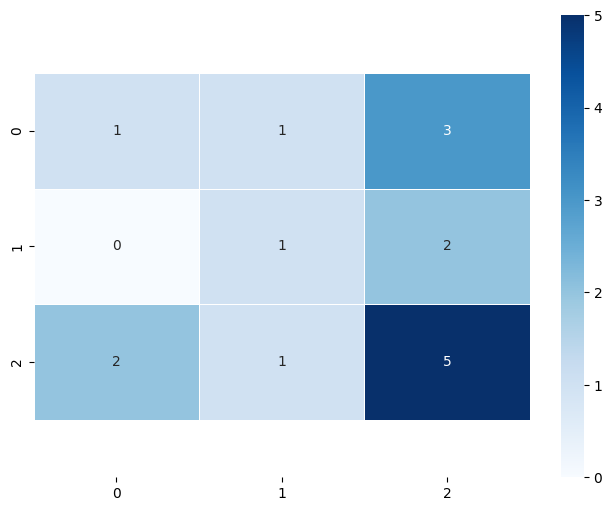

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1,1,1,0,0,0,0,0,2,2,2,2,2,2,2,2]
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2,2]
# 혼동 행렬 틀을 만들어 플로팅
c_mat = confusion_matrix(actual,prediction)
plt.figure(figsize=(8,6))
sns.heatmap(c_mat,annot=True,fmt="d",cmap='Blues',linewidths=.5)
# 위 아래 범위 0.5씩 더 확보
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
plt.savefig('confusion_matrix.png')
plt.show()

## 9.3 전이 학습 Transfer learning
- 기존의 지식을 우리가 풀고자 하는 문제에 적용하여 학습하는 방법

### 9.3.1 사전 학습 모델 pretrained model

In [ ]:
# CIFAR10을 위한 ResNet18 불러오기
# 불러온 모델은 CIFAR10보다 큰 ImageNet 데이터에 맞춰진 모델이므로
# 원래 첫 번째 합성곱 층의 필터 사이즈가 7x7인데 CIFAR10 데이터에는 큰 사이즈므로 3x3 필터로 변경함

model = torchvision.models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
# 원래 모델의 마지막 출력 노드가 1000이기 때문에 우리 데이터에 맞춰 10개로 변경
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,10)
model = model.to(device)

### 9.3.2 모델 프리징 Model freezing
- 기존의 일부 모델 변수들을 그대로 사용하기 위해 업데이트가 되지 않도록 하는 방법

In [ ]:
import torch
import torchvision
import torch.nn as nn

# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 모델 불러오기

model = torchvision.models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,10)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.6MB/s]


In [ ]:
# 모델 파라미터명 확인하기

# 가중치, 편향 목록 (0~9번째는 합성곱 층에 대한 가중치와 편향, 10번 이후는 분류기의 가중치와 편향)
for i, (name, param) in enumerate(model.named_parameters()):
  print(i,name)

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias


In [ ]:
# 변수 프리징하기

for i, (name, param) in enumerate(model.named_parameters()):
  param.requires_grad = False # False로 두어 학습시 업데이트가 되지 않도록
  if i == 9: # 합성곱 층에 대한 가중치와 편향(9번까지)만 프리징이 되면 for문 멈춤
    print('end')
    break

end


In [ ]:
# Requires_grad 확인하기

f_list = [0,3,6,8,10]
c_list = [1,4,6]
for i in f_list:
  print(model.features[i].weight.requires_grad)
  print(model.features[i].bias.requires_grad)
for j in c_list:
  print(model.classifier[j].weight.requires_grad)
  print(model.classifier[j].bias.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


## 9.4 준지도 학습 Semi-supervised learning
- 정답이 있는 데이터와 정답이 없는 데이터를 함께 사용하여 모델을 학습시키는 방법

### 9.4.1 의사 라벨링 Pseudo labeling
- 준지도 학습 중 가장 기본적으로 사용되는 방법으로, 우리가 라벨이 없는 데이터를 지도 학습에 사용하려면 라벨을 달아 주어야 함
- 따라서 이미 학습된 모델을 이용하여 라벨링이 되지 않는 데이터를 예측한 후, 그 예측값을 기준으로 라벨링을 하여 기존의 학습 데이터와 함께 학습에 사용하는 방법이 의사 라벨링

In [33]:
# 라이브러리 불러오기

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # for문의 진행 상황을 알려주는 라이브러리

In [34]:
# GPU 연산 정의

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
# 데이터셋 정의하기

class MyDataset(Dataset):
  def __init__(self,x_data,y_data,transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)

  def __getitem__(self,index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

In [71]:
# 데이터 전처리 정의하기

class TrainTransform:
  def __call__(self,sample):
    inputs, labels = sample
    transf = transforms.Compose([transforms.ToPILImage(),
                                 transforms.RandomHorizontalFlip(), transforms.ToTensor()])
    final_output = transf(inputs)
    return final_output, labels

In [72]:
# 데이터, 라벨, 클래스 수, 나눠지는 목표 데이터 개수
def balanced_subset(data, labels, num_cls, num_data):
    num_data_per_class = num_data // num_cls  # 각 클래스의 데이터 개수 정의

    # 나눠지는 두 개의 세트를 저장하기 위해 데이터와 라벨 텐서를 각각 2개씩 정의
    data1 = torch.empty((0,) + data.shape[1:], dtype=data.dtype)
    data2 = torch.empty((0,) + data.shape[1:], dtype=data.dtype)
    labels1 = torch.empty((0,), dtype=labels.dtype)
    labels2 = torch.empty((0,), dtype=labels.dtype)

    # 각 클래스마다 정의된 데이터 개수만큼 무작위로 뽑아 저장
    for cls in range(num_cls):
        idx = torch.nonzero(labels == cls, as_tuple=True)[0]
        shuffled_idx = torch.randperm(len(idx))
        data1 = torch.cat([data1, data[idx[shuffled_idx[:num_data_per_class]]]], dim=0)
        data2 = torch.cat([data2, data[idx[shuffled_idx[num_data_per_class:]]]], dim=0)
        labels1 = torch.cat([labels1, labels[idx[shuffled_idx[:num_data_per_class]]]], dim=0)
        labels2 = torch.cat([labels2, labels[idx[shuffled_idx[num_data_per_class:]]]], dim=0)

    return data1, data2, labels1, labels2


In [73]:
# 숫자 판별 MNIST 데이터 불러오기
# 라벨링된 데이터가 2000개만 있다고 가정하고 학습 데이터, 검증 데이터를 각각 1000개씩 사용하며 나머지 데이터는 라벨링이 안 된 데이터라 가정

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
labeled_data, unlabeled_data, labels, unlabels = balanced_subset(trainset.data, trainset.targets, num_cls=10, num_data=2000)
train_images, val_images, train_labels, val_labels = balanced_subset(labeled_data, labels, num_cls=10, num_data=1000)

In [74]:
# 데이터로더 정의하기
# CNN은 4차원 입력 이미지가 필요함. 하지만 1채널인 MNIST 데이터는 (배치사이즈, 이미지 너비, 이미지 높이) 형태인 3차원이기 때문에
# unsqueeze(1)를 통해 3차원 텐서를 4차원 텐서 (배치사이즈, 1, 이미지 너비, 이미지 높이)로 변환함

train_images = train_images.unsqueeze(1)
val_images = val_images.unsqueeze(1)
# 학습 데이터에는 Traintransform() 적용, 나머지 세트 5, 8에 대해서는 적용X
trainset = MyDataset(train_images, train_labels, transform=TrainTransform())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
validationset = MyDataset(val_images, val_labels)
valloader = torch.utils.data.DataLoader(validationset, batch_size=128, shuffle=False)
unlabeled_images = unlabeled_data.unsqueeze(1)
unlabeledset = MyDataset(unlabeled_images, unlabels)
unlabeledloader = torch.utils.data.DataLoader(unlabeledset, batch_size=256, shuffle=True)

In [75]:
# 평가 데이터 불러옴
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False)

In [76]:
# 모델 정의하기

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1,64,3), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,192,3,padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(192*6*6,1024), nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024,512), nn.ReLU(),
        nn.Linear(512,10)
    )

  def forward(self,x):
    x = self.features(x)
    x = x.view(-1,192*6*6)
    x = self.classifier(x)
    return x

model = Net().to(device)

In [77]:
# 손실 함수 및 최적화 기법 정의하기

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [80]:
# 정확도 평가 함수 정의하기

def accuracy(dataloader):
  correct = 0
  total = 0
  with  torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].float().to(device), data[1].to(device)
      outputs = model(images)
      _,predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100*correct/total
  model.train()
  return acc

In [82]:
# 지도 학습 수행하기
# 기준 성능을 알아보기 위해 1000개의 라벨링된 데이터로만 학습 진행

best_acc = 0 # 검증 정확도 기준으로 모델 저장하기 위해 변수 선언
# 학습 데이터를 이용해 학습을 하고 학습 정확도 계산
for epoch in range(501):
  correct = 0
  total = 0
  for traindata in trainloader:
    inputs, labels = traindata[0].to(device).float(), traindata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _,predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # 검증 정확도를 계산하여 가장 높은 검증 정확도를 기준으로 모델 파라미터를 저장
    val_acc = accuracy(valloader)
    if val_acc >= best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), './models/cifar_model_for_pseudo_baseline.pth')
      print('[%d] train acc: %.2f, validation acc: %.2f - Saved the best model' %(epoch,100*correct/total,val_acc))
    elif epoch % 10 == 0: # epoch 10마다 학습 정확도와 검증 정확도 출력
      print('[%d] train acc: %.2f, validation acc: %.2f' %(epoch,100*correct/total,val_acc))

[0] train acc: 17.97, validation acc: 20.30 - Saved the best model
[0] train acc: 17.97, validation acc: 37.20 - Saved the best model
[0] train acc: 22.40, validation acc: 29.00
[0] train acc: 24.02, validation acc: 34.10
[0] train acc: 26.56, validation acc: 44.50 - Saved the best model
[0] train acc: 28.91, validation acc: 62.90 - Saved the best model
[0] train acc: 32.03, validation acc: 49.90
[0] train acc: 32.80, validation acc: 46.40
[1] train acc: 56.90, validation acc: 63.30 - Saved the best model
[1] train acc: 57.25, validation acc: 66.70 - Saved the best model
[1] train acc: 57.50, validation acc: 67.00 - Saved the best model
[2] train acc: 65.10, validation acc: 67.00 - Saved the best model
[2] train acc: 69.20, validation acc: 70.40 - Saved the best model
[3] train acc: 77.34, validation acc: 71.40 - Saved the best model
[3] train acc: 78.78, validation acc: 74.10 - Saved the best model
[3] train acc: 78.46, validation acc: 75.90 - Saved the best model
[3] train acc: 78.50

In [83]:
# 지도 학습 성능 평가하기 (베스트 모델)

model.load_state_dict(torch.load('./models/cifar_model_for_pseudo_baseline.pth'))
accuracy(testloader)

95.3

In [84]:
# 준지도 학습1을 위한 모델을 재정의하기
# 모델 파라미터를 초기화

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

준지도 학습 1 수행하기
- 의사 라벨링은 정확한 라벨과 부정확한 라벨이 섞여 있으므로 훈련 데이터와 동일하게 모델 최적화에 사용한다면 좋지 못한 결과 초래
- 따라서 훈련 라벨과 의사 라벨을 구분하여 따로 손실 함수(L_t와 L_p)를 계산한 뒤 둘을 더해 손실 함수 L 정의
- 의사 라벨을 이용하는 손실 함수 부분에 가중치 alpha로 학습 개입 조절 가능
  - alpha=0이면 학습 데이터로만 모델 최적화
  - alpha가 커질수록 의사 라벨의 영향도가 더 커진다는 의미
  - 적절한 alpha 구하자

In [85]:
alpha = 0
alpha_t = 1e-4
# 처음 epoch 100번까지는 alpha=0 으로 학습 진행. 이후는 일정하게 alpha를 높여 진행
# 450회가 지나면 alpha를 alpha_t로 고정하여 학습 진행하여 마무리
T1 = 100
T2 = 450
best_acc = 0

In [88]:
for epoch in range(501):
  correct = 0
  total = 0
  # zip을 이용하여 두 개의 데이터로더를 동시에 사용 가능함
  for traindata, pseudodata in zip(trainloader, unlabeledloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs = pseudodata[0].float().to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    # 0보다 크면 의사 라벨로 함께 이용하여 손실 함수 계산
    if alpha > 0:
      poutputs = model(pinputs)
      _,plabels = torch.max(poutputs.detach(),1)
      loss = criterion(outputs,labels) + alpha*criterion(poutputs, plabels)
    # alpha=0 이면 학습 데이터만 이용하여 손실 함수 계산
    else:
      loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() # 최적화
    # 학습 정확도 계산을 위해 정답 개수와 총 라벨 개수 누적
    _,predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t*(epoch - T1)/(T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), './models/cifar_model_for_pseudo_label.pth')
    print('[%d] train acc: %.2f, validation acc: %.2f - Saved the best model' %(epoch,100*correct/total,val_acc))
  elif epoch % 10 == 0:
    print('[%d] train acc: %.2f, validation acc: %.2f' %(epoch,100*correct/total,val_acc))

[0] train acc: 99.60, validation acc: 90.20
[5] train acc: 99.50, validation acc: 94.20 - Saved the best model
[10] train acc: 99.60, validation acc: 90.70
[20] train acc: 99.40, validation acc: 90.20
[30] train acc: 99.10, validation acc: 91.50
[40] train acc: 99.90, validation acc: 91.10
[50] train acc: 99.80, validation acc: 92.00
[60] train acc: 99.60, validation acc: 91.40
[70] train acc: 99.90, validation acc: 92.20
[80] train acc: 99.20, validation acc: 91.70
[90] train acc: 99.90, validation acc: 92.60
[100] train acc: 99.80, validation acc: 87.80
[110] train acc: 99.80, validation acc: 89.50
[120] train acc: 99.50, validation acc: 91.70
[130] train acc: 99.70, validation acc: 91.50
[140] train acc: 100.00, validation acc: 88.10
[150] train acc: 99.90, validation acc: 90.20
[160] train acc: 100.00, validation acc: 91.80
[170] train acc: 99.70, validation acc: 88.70
[180] train acc: 99.60, validation acc: 90.10
[190] train acc: 99.70, validation acc: 89.50
[200] train acc: 99.80

In [89]:
# 준지도 학습1 성능 평가하기
# 평가 정확도 내려감...?

model.load_state_dict(torch.load('./models/cifar_model_for_pseudo_label.pth'))
accuracy(testloader)

95.14

준지도 학습 2 를 위한 모델을 재정의하기

In [90]:
# 이번 방법에서는 학습 데이터로 학습된 사전 훈련 모델을 가지고 의사 라벨을 생성한 뒤 이를 실제 라벨처럼 사용해 봄

model = Net().to(device)
model.load_state_dict(torch.load('./models/cifar_model_for_pseudo_baseline.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [92]:
# 의사 라벨 생성하기

# 사전 학습 모델로 예측된 출력 벡터의 가장 큰 원소가 0.99가 넘으면 의사 라벨로 사용
pseudo_threshold = 0.99
# 데이터를 모을 빈 텐서
pseudo_images = torch.tensor([],dtype=torch.float)
pseudo_labels = torch.tensor([],dtype=torch.long)
with torch.no_grad():
  for data in tqdm(unlabeledloader):
    model.eval()
    images = data[0].float().to(device)
    outputs = model(images)
    # 출력 벡터의 원소는 0과 1 사이의 값이 아닐 수 있음. 따라서 값은 0부터 1까지로 만들어 주기 위해 softmax 함수 사용
    outputs = torch.nn.functional.softmax(outputs,dim=1)
    max_val, predicted = torch.max(outputs.detach(),1)
    # 만약 현재 배치에 0.99 이상을 만족하는 데이터가 1개 이상 있다면
    idx = np.where(max_val.cpu().numpy() >= pseudo_threshold)[0]
    if len(idx) > 0:
      # 데이터 누적
      pseudo_images = torch.cat((pseudo_images, images.cpu()[idx]),0)
      pseudo_labels = torch.cat((pseudo_labels, predicted.cpu()[idx]),0)

100%|██████████| 227/227 [00:18<00:00, 12.32it/s]


In [93]:
# 준지도 학습2를 위한 데이터로더 정의하기

pseudo_dataset = MyDataset(pseudo_images, pseudo_labels)
pseudoloader = torch.utils.data.DataLoader(pseudo_dataset,batch_size=256,shuffle=True)

In [94]:
# 준지도 학습2 수행하기

alpha = 0
alpha_t = 1e-4
# 처음 epoch 20번까지는 alpha=0 으로 학습 진행. 이후는 일정하게 alpha를 높여 진행
# 450회가 지나면 alpha를 alpha_t로 고정하여 학습 진행하여 마무리
T1 = 20
T2 = 450
best_acc = 0

In [95]:
for epoch in range(501):
  correct = 0
  total = 0
  # zip을 이용하여 두 개의 데이터로더를 동시에 사용 가능함
  for traindata, pseudodata in zip(trainloader, pseudoloader):
    inputs, labels = traindata[0].to(device), traindata[1].to(device) # 학습 데이터 불러옴
    pinputs, plabels = pseudodata[0].to(device), pseudodata[1].to(device) # 의사 라벨 데이터 불러옴
    optimizer.zero_grad()
    outputs = model(inputs)
    poutputs = model(pinputs)
    loss = criterion(outputs,labels) + alpha*criterion(poutputs, plabels)
    loss.backward()
    optimizer.step() # 최적화
    # 학습 정확도 계산을 위해 정답 개수와 총 라벨 개수 누적
    _,predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  if (epoch > T1) and (epoch < T2):
    alpha = alpha_t*(epoch - T1)/(T2 - T1)
  elif epoch >= T2:
    alpha = alpha_t
  val_acc = accuracy(valloader)
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), './models/cifar_model_for_pseudo_label2.pth')
    print('[%d] train acc: %.2f, validation acc: %.2f - Saved the best model' %(epoch,100*correct/total,val_acc))
  elif epoch % 10 == 0:
    print('[%d] train acc: %.2f, validation acc: %.2f' %(epoch,100*correct/total,val_acc))

[0] train acc: 100.00, validation acc: 92.00 - Saved the best model
[5] train acc: 99.20, validation acc: 92.30 - Saved the best model
[8] train acc: 99.60, validation acc: 92.30 - Saved the best model
[9] train acc: 99.30, validation acc: 93.10 - Saved the best model
[10] train acc: 99.70, validation acc: 89.80
[20] train acc: 99.80, validation acc: 89.20
[30] train acc: 99.80, validation acc: 92.40
[33] train acc: 99.60, validation acc: 94.10 - Saved the best model
[40] train acc: 99.80, validation acc: 93.60
[46] train acc: 99.70, validation acc: 94.50 - Saved the best model
[50] train acc: 99.70, validation acc: 92.90
[60] train acc: 99.70, validation acc: 92.30
[70] train acc: 99.70, validation acc: 93.30
[80] train acc: 100.00, validation acc: 93.50
[90] train acc: 99.80, validation acc: 93.00
[100] train acc: 99.80, validation acc: 92.90
[110] train acc: 99.90, validation acc: 93.10
[120] train acc: 99.80, validation acc: 92.60
[130] train acc: 99.90, validation acc: 91.40
[140]

In [96]:
# 준지도 학습2 성능 평가하기

model.load_state_dict(torch.load('./models/cifar_model_for_pseudo_label2.pth'))
accuracy(testloader)

95.43